<h3>    Target:  </h3>
<h6>Increase model capacity at the end (add layer after GAP) </h6> 
<h6>Fix DropOut, add it to each layer  </h6>
<h6>Add StepLR</h6>
<h6>Image augmentation of random rotation is considered</h6>
<h3>    Results: </h3>
<h6>Parameters: 7,862</h6>
<h6>Best Train Accuracy: 99.02   </h6> 
<h6>Best Test Accuracy:  99.44 (11th Epoch), 99.45 (13th Epoch)  </h6>
<h3>    Analysis: </h3>
<h6>Changing batchsize from 128 to 64 had an improvement in accuracy</h6>
<h6>Changing the step size to 9 had an improvement in accuracy</h6>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/ERA2/session7/'
import model

/content/gdrive/MyDrive/ERA2/session7


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                      #  transforms.RandomErasing(p=0.2, scale=(0.02, 0.23), ratio=(0.2, 2.3), value=0, inplace=False)
                                      # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


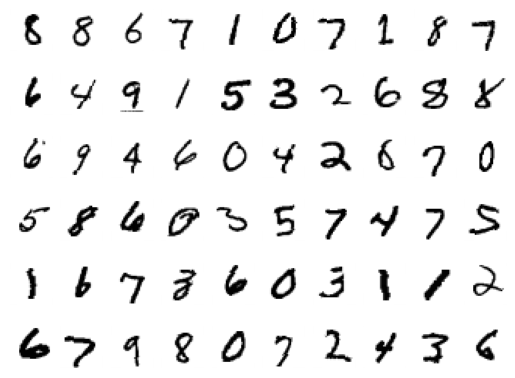

In [7]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_3 = model.Model_3().to(device)
summary(model_3, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 14, 24, 24]           1,260
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
           Dropout-7           [-1, 14, 24, 24]               0
            Conv2d-8           [-1, 10, 24, 24]             140
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,260
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
          Dropout-13           [-1, 14, 10, 10]               0
           Conv2d-14           [-1

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR

model_3 =  model.Model_3().to(device)
optimizer = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=9, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_3, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_3, device, test_loader)

EPOCH: 0


Loss=0.07331546396017075 Batch_id=937 Accuracy=89.57: 100%|██████████| 938/938 [00:27<00:00, 34.44it/s]



Test set: Average loss: 0.0774, Accuracy: 9773/10000 (97.73%)

EPOCH: 1


Loss=0.10633811354637146 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:29<00:00, 31.51it/s]



Test set: Average loss: 0.0487, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Loss=0.05256004258990288 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:29<00:00, 32.28it/s]



Test set: Average loss: 0.0341, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.05706057325005531 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:31<00:00, 29.53it/s]



Test set: Average loss: 0.0352, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.010858314111828804 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:30<00:00, 31.01it/s]



Test set: Average loss: 0.0291, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.010463310405611992 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]



Test set: Average loss: 0.0311, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.026020435616374016 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:28<00:00, 32.36it/s]



Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.19317395985126495 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:30<00:00, 30.40it/s]



Test set: Average loss: 0.0242, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.023823902010917664 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:30<00:00, 31.08it/s]



Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.11532703042030334 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:30<00:00, 31.11it/s]



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.010572360828518867 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:28<00:00, 33.46it/s]



Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.1775161325931549 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:29<00:00, 31.64it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.09226513653993607 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:29<00:00, 31.98it/s]



Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.09895390272140503 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:30<00:00, 31.21it/s]



Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.02569057233631611 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:29<00:00, 31.87it/s]



Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

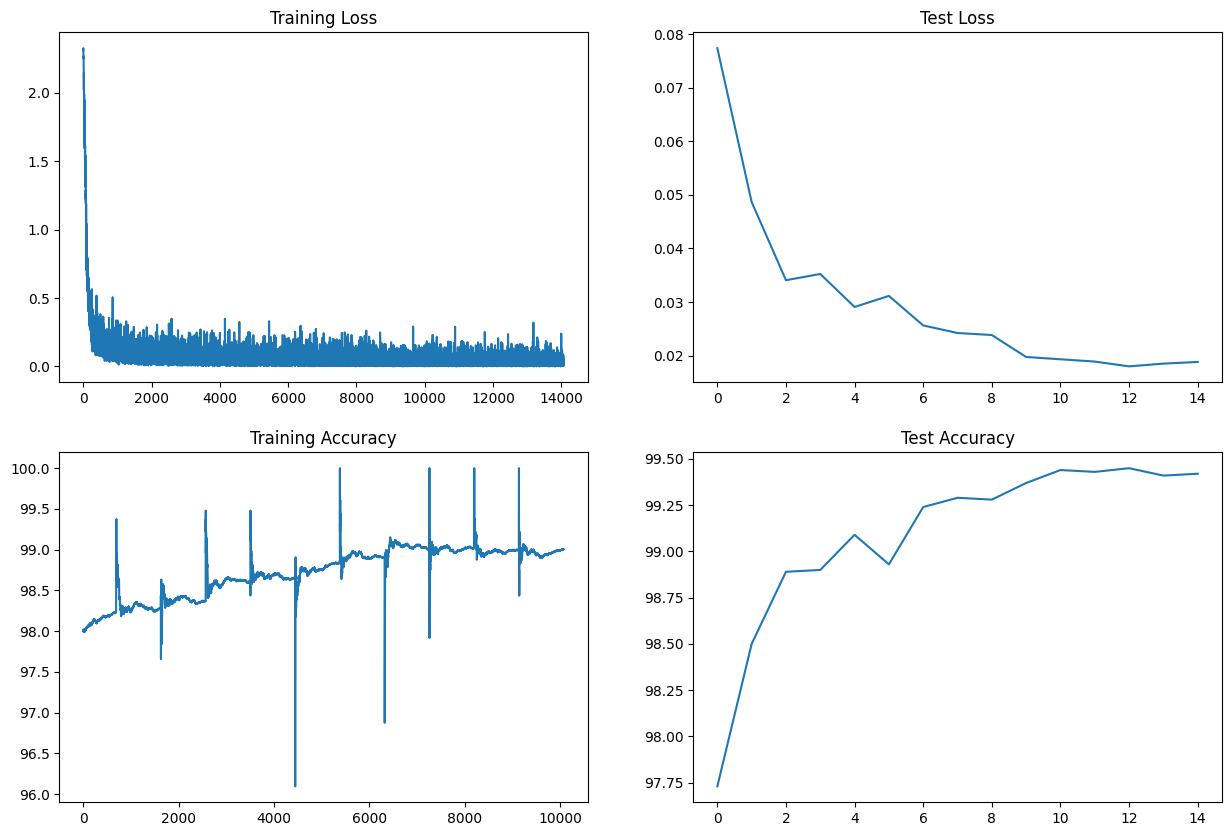

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")